# Travelling Salesman Problem with subtour elimination

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ampl/ampls-api/blob/master/python/examples/notebooks/tsp_simple_cuts_generic.ipynb)

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ampl/ampls-api/blob/master/python/examples/notebooks/tsp_simple_cuts_generic.ipynb)

Notebook on GitHub: https://github.com/ampl/ampls-api/blob/master/python/examples/notebooks/tsp_simple_cuts_generic.ipynb

This example shows how to solve a TSP  by eliminating subtours using:

1. amplpy (defining the subtour elimination constraint in AMPL and instantiating it appropriately)
2. ampls (adding cuts directly from the solver callback)

### Options

In [1]:
!test -d ampls-api || test -d ../tsp/ || git clone https://github.com/ampl/ampls-api.git

In [2]:
import os
if os.path.isdir('ampls-api'):
    os.chdir('ampls-api/python/examples/notebooks/')
SOLVER = "gurobi"
SOLVER_OPTIONS = ['outlev=1']
USE_CALLBAKCS = True
PLOTSUBTOURS = True
TSP_FILE = "../tsp/a280.tsp"

### Setup

In [3]:
!pip install -q amplpy ampltools amplpy-gurobi amplpy-cplex
!pip install -q tsplib95 matplotlib

### Google Colab & Kaggle interagration

In [4]:
import os
RUNNING_IN_GOOGLE_COLAB = 'COLAB_GPU' in os.environ
RUNNING_IN_KAGGLE = os.path.abspath(os.curdir).startswith('/kaggle/')
RUNNING_IN_THE_CLOUD = RUNNING_IN_GOOGLE_COLAB or RUNNING_IN_KAGGLE

In [20]:
# If you have an AMPL Cloud License or an AMPL CE license, you can use it on Google Colab and similar platforms.
# Note: Your license UUID should never be shared. Please make sure you delete the license UUID
# and rerun this cell before sharing the notebook with anyone.
LICENSE_UUID = None
# You can install individual modules from https://portal.ampl.com/dl/modules/
MODULES = ['ampl', 'coin', SOLVER]
# Set to True in order to install AMPL only once 
RUN_ONCE = True
if RUNNING_IN_THE_CLOUD:
    from ampltools import ampl_installer
    ampl_dir = os.path.abspath(os.path.join(os.curdir, 'ampl.linux-intel64'))
    ampl_installer(ampl_dir, modules=MODULES, license_uuid=LICENSE_UUID, run_once=RUN_ONCE, verbose=True)
    os.environ['PATH'] += os.pathsep + ampl_dir

Already installed. Skipping.
Activating demo license.


### Imports

In [6]:
# Import utilities
from amplpy import AMPL, DataFrame  # pip install amplpy
if SOLVER == "gurobi":
    import amplpy_gurobi as ampls   # pip install amplpy-gurobi
elif SOLVER == "cplex":
    import amplpy_cplex as ampls    # pip install amplpy-cplex
elif SOLVER == "xpress":
    import amplpy_xpress as ampls   # pip install amplpy-gurobi
import tsplib95 as tsp              # pip install tsplib95
import matplotlib.pyplot as plt     # pip install matplotlib
import matplotlib.colors as colors
from time import time
plt.rcParams['figure.dpi'] = 200

### Register jupyter magics for AMPL

In [7]:
from amplpy import register_magics
register_magics('_ampl_cells')  # Store %%ampl cells in the list _ampl_cells

### Define TSP model in AMPL

In [8]:
%%ampl
set NODES ordered;
param hpos {NODES};
param vpos {NODES};

set PAIRS := {i in NODES, j in NODES: ord(i) < ord(j)};

param distance {(i,j) in PAIRS}
   := sqrt((hpos[j]-hpos[i])**2 + (vpos[j]-vpos[i])**2);

var X {PAIRS} binary;

minimize Tour_Length: sum {(i,j) in PAIRS} distance[i,j] * X[i,j];

subject to Visit_All {i in NODES}:
   sum {(i, j) in PAIRS} X[i,j] + sum {(j, i) in PAIRS} X[j,i] = 2;

Function to load TSP data files and return a dictionary of (nodeid : coordinate)

In [9]:
def getDictFromTspFile(tspFile):
    p = tsp.load(tspFile)
    if not p.is_depictable:
        print("Problem is not depictable!")

    # Amendments as we need the nodes lexographically ordered
    nnodes = len(list(p.get_nodes()))
    i = 0
    while nnodes>1:
        nnodes = nnodes/10
        i+=1
    formatString = f"{{:0{i}d}}"
    nodes = {formatString.format(value) : p.node_coords[index+1] for index, value in enumerate(p.get_nodes())}
    return nodes

Create AMPL object with amplpy and load model and data

In [10]:
# Get the model from the cell above
tsp_model = _ampl_cells[0]

# Load model in AMPL
ampl = AMPL()
ampl.eval(tsp_model)
ampl.option["solver"] = SOLVER
ampl.option[SOLVER + "_options"] = ' '.join(SOLVER_OPTIONS)

# Set problem data from tsp file
nodes = getDictFromTspFile(TSP_FILE)

# Pass them to AMPL using a dataframe
df = DataFrame(index=[('NODES')], columns=['hpos', 'vpos'])
df.setValues(nodes)
ampl.setData(df, "NODES")

# Set some globals that never change during the execution of the problem
NODES = set(nodes.keys())
CPOINTS = {node : complex(coordinate[0], coordinate[1]) for (node, coordinate) in nodes.items()}

Define some helpers functions to plot the tours

In [11]:
def plotTours(tours: list, points_coordinate: dict):
    # Plot all the tours in the list each with a different color
    colors = ['b', 'g', 'c', 'm', 'y', 'k']
    for i, tour in enumerate(tours):
        tourCoordinates = [points_coordinate[point.strip("'")] for point in tour]
        color = colors[i % len(colors)]
        plot_all(tourCoordinates, color = color)
    plt.show()

def plot_all(tour, alpha=1, color=None):
    # Plot the tour as blue lines between blue circles
    plotline(list(tour) + [tour[0]], alpha=alpha, color=color)
    plotline([tour[0]], 's', alpha=alpha, color=color)
    
def plotline(points, style='o-', alpha=1, color=None):
    "Plot a list of points (complex numbers) in the 2-D plane."
    X, Y = XY(points)
    if color:
        plt.plot(X, Y, style, alpha=alpha, color=color)
    else:
        plt.plot(X, Y, style, alpha=alpha)
    
def XY(points):
    "Given a list of points, return two lists: X coordinates, and Y coordinates."
    return [p.real for p in points], [p.imag for p in points]

Define some helper functions to help with the graphs (e.g. get the subtour given a set of arcs)

In [12]:
# Graphs helper routines
def trasverse(node, arcs: set, allnodes: set, subtour = None) -> list:
    # Trasverses all the arcs in the set arcs, starting from node
    # and returns the tour
    if not subtour:
        subtour = list()
    # Find arcs involving the current node
    myarcs = [(i,j) for (i,j) in arcs if node == i or node == j]
    if len(myarcs) == 0:
        return 
    # Append the current node to the current subtour
    subtour.append(node)

    # Use the first arc found
    myarc = myarcs[0]
    # Find destination (or origin) node
    destination = next(i for i in myarc if i != node)
    # Remove from arcs and nodes to visit
    arcs.remove(myarc)
    if node in allnodes:
        allnodes.remove(node)

    trasverse(destination, arcs, allnodes, subtour)
    return subtour


def findSubTours(arcs: set, allnodes: set):
    """Find all the subtours defined by a set of arcs and
       return them as a list of list
    """
    subtours = list()
    allnodes = allnodes.copy()
    while len(allnodes) > 0:
        l = trasverse(next(iter(allnodes)), arcs, allnodes)
        subtours.append(l)
    return subtours

AMPLPY implementation of sub-tours elimination

In [13]:
def amplSubTourElimination(ampl: AMPL):
    # Add the constraint and the needed parameters
    subToursAMPL = """param nSubtours >= 0 integer, default 0;
    set SUB {1..nSubtours} within NODES;

    subject to Subtour_Elimination {k in 1..nSubtours}:
    sum {i in SUB[k], j in NODES diff SUB[k]} 
    if (i, j) in PAIRS then X[i, j] else X[j, i] >= 2;"""
    ampl.eval(subToursAMPL)

    nSubtoursParam = ampl.getParameter("nSubtours")
    SubtoursSet = ampl.getSet("SUB")

    allsubtours = list()
    while True: # Repeat until the solution contains only one tour
        ampl.solve()
        # Get solution
        ARCS = ampl.getData("{(i,j) in PAIRS : X[i,j] > 0} X[i,j];")
        ARCS = set([(i, j) for (i, j, k)in ARCS.toList()])
        subtours = findSubTours(ARCS, NODES)
        # If we have only one tour, the solution is valid
        if len(subtours) <= 1:
            break
        print(f"Found {len(subtours)} subtours, plotting them and adding cuts")
        if PLOTSUBTOURS:
            plotTours(subtours, CPOINTS)
        # Else add the current tours to the list of subtours
        allsubtours.extend(subtours)
        # And add those to the constraints by assigning the values to
        # the parameter and the set
        nSubtoursParam.set(len(allsubtours))
        for (i, tour) in enumerate(allsubtours):
            SubtoursSet[i+1].setValues(tour)

ampls callbacks implementation of subtours elimination

In [14]:
# Callback class that actually add the cuts if subtours are found in a solution
class MyCallback(ampls.GenericCallback):
    def __init__(self): 
        # Constructor, simply sets the iteration number to 0
        super().__init__()
        self.iteration = 0 
    def run(self):
        try:
            # For each solution
            if self.getAMPLWhere() == ampls.Where.MIPSOL:
                self.iteration += 1
                print(f"\nIteration {self.iteration}: Finding subtours")
                sol = self.getSolutionVector()
                arcs = [xvars[i] for i, value in enumerate(sol) if value > 0]
                subTours = findSubTours(set(arcs), set(vertices))
                if len(subTours) ==1:
                    print("No subtours detected. Not adding any cut")
                    return 0
                print(f"Adding {len(subTours)} cuts")
                if PLOTSUBTOURS:
                    plotTours(subTours, CPOINTS)
                for subTour in subTours:
                    st1 = set(subTour)
                    nst1 = set(vertices) - st1
                    externalArcs = [(i, j) if i < j else (j, i) for i in st1 for j in nst1]
                    varsExternalArcs = [xinverse[i, j] for (i, j) in externalArcs]
                    coeffs = [1 for i in range(len(varsExternalArcs))]
                    if PLOTSUBTOURS:
                        print("Adding cut for subtour:", st1)
                    self.addLazyIndices(varsExternalArcs, coeffs, ampls.CutDirection.GE, 2)
                    if len(subTours) == 2:
                        return 0
                print("Continue solving")
            return 0
        except Exception as e:
            print('Error:', e)
            return 1

In [15]:
# Global variables to store entities needed by the callbacks
# that never change
xvars = None
xinverse = None
vertices = None
def solverSubTourElimination(ampl: AMPL, solver, solver_options):
    global xvars, xinverse, vertices
    # Export the model using ampls
    model = ampl.exportModel(solver, solver_options)
    model.enableLazyConstraints()

    # Get the global maps between solver vars and AMPL entities
    varMap = model.getVarMapFiltered("X")
    #print("varMap:", varMap)
    inverse = model.getVarMapInverse()
    xvars = {index: ampls.var2tuple(var)[1:] for var, index in varMap.items()}
    xinverse = {ampls.var2tuple(var)[1:]: index for index, var in inverse.items()}
    vertices = list(sorted(set([x[0] for x in xvars.values()] + [x[1] for x in xvars.values()])))

    # Assign the callback
    callback = MyCallback()
    model.setCallback(callback)
    print("Start optimization")
    # Start the optimization
    model.optimize()
    # Import the solution back to AMPL
    ampl.importSolution(model)

Script running the optimization

Start optimization

Iteration 1: Finding subtours
Adding 5 cuts


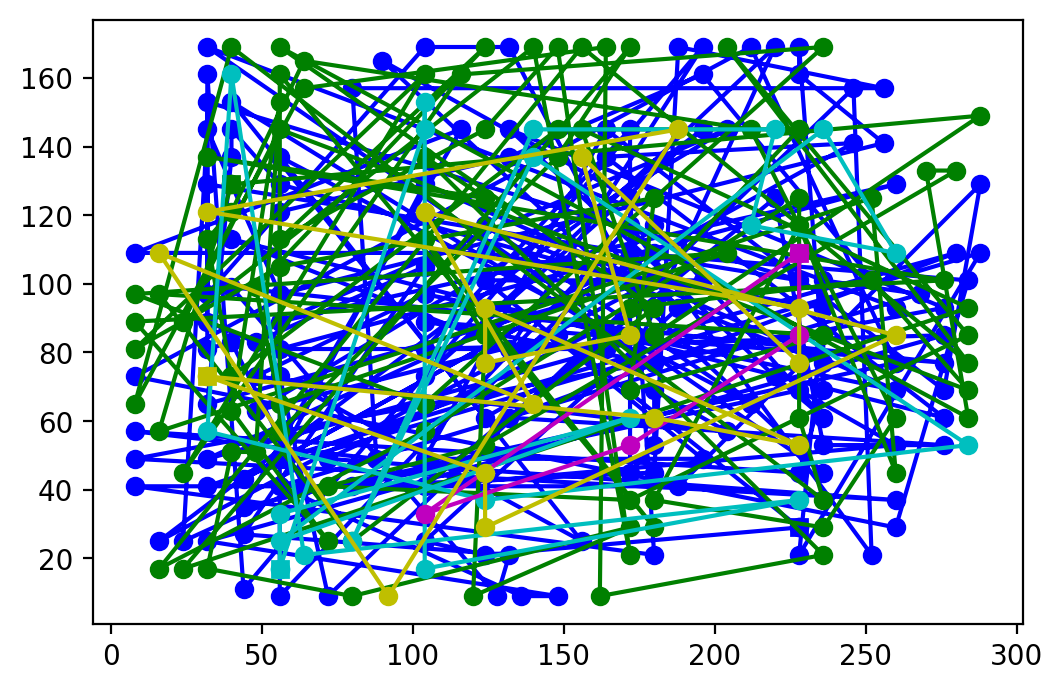

Adding cut for subtour: {'220', '093', '091', '078', '085', '233', '211', '129', '234', '159', '187', '148', '144', '215', '117', '153', '073', '142', '095', '141', '054', '114', '272', '014', '133', '128', '099', '190', '033', '204', '126', '227', '256', '199', '279', '180', '120', '086', '105', '241', '094', '265', '230', '081', '104', '123', '092', '041', '008', '207', '048', '034', '164', '200', '162', '268', '224', '059', '018', '063', '255', '135', '077', '210', '168', '043', '158', '189', '191', '005', '203', '113', '009', '075', '173', '202', '178', '042', '149', '221', '011', '002', '150', '137', '027', '176', '116', '155', '156', '232', '242', '032', '205', '107', '080', '229', '247', '046', '064', '017', '277', '223', '261', '195', '231', '209', '010', '157', '119', '112', '051', '257', '083', '269', '100', '118', '193', '004', '134', '214', '013', '250', '090', '216', '225', '053', '271', '264', '181', '267', '136', '108', '243', '065', '161', '069', '047', '006', '015', '0

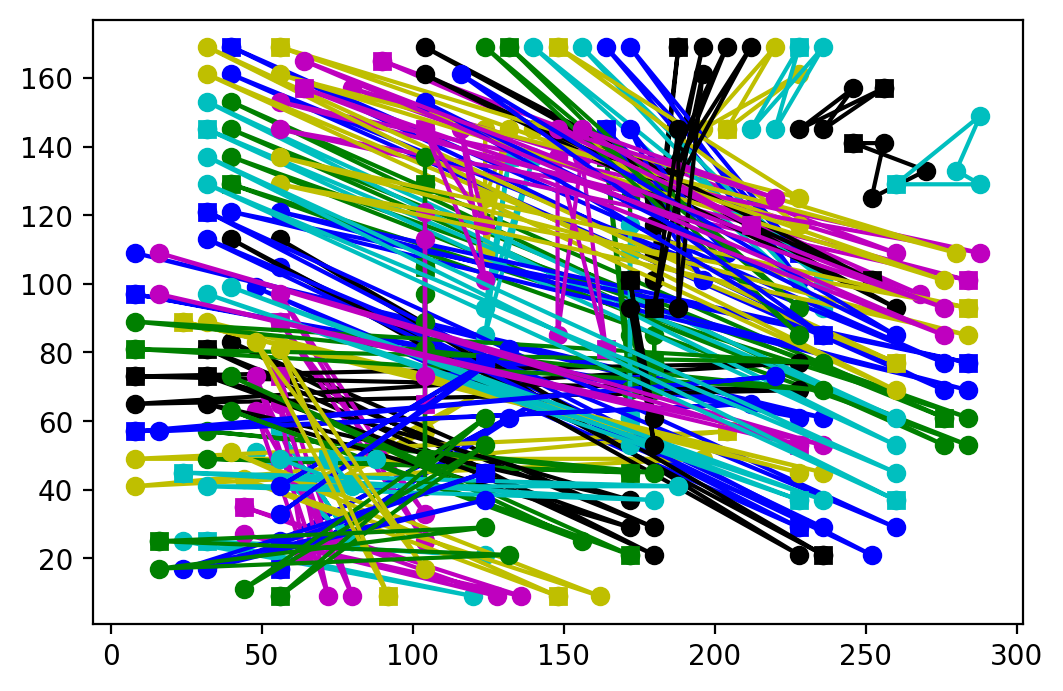

Adding cut for subtour: {'220', '219', '061', '062'}
Adding cut for subtour: {'235', '046', '045', '236'}
Adding cut for subtour: {'187', '188', '094', '093'}
Adding cut for subtour: {'190', '189', '091', '092'}
Adding cut for subtour: {'176', '175', '105', '106'}
Adding cut for subtour: {'196', '085', '195', '086'}
Adding cut for subtour: {'211', '069', '212', '070'}
Adding cut for subtour: {'233', '047', '048', '234'}
Adding cut for subtour: {'151', '129', '152', '130'}
Adding cut for subtour: {'117', '163', '164', '118'}
Adding cut for subtour: {'127', '128', '154', '153'}
Adding cut for subtour: {'208', '073', '074', '207'}
Adding cut for subtour: {'102', '101', '180', '179'}
Adding cut for subtour: {'140', '141', '142', '139'}
Adding cut for subtour: {'227', '054', '053', '228'}
Adding cut for subtour: {'167', '113', '114', '168'}
Adding cut for subtour: {'272', '010', '009', '271'}
Adding cut for subtour: {'013', '014', '267', '268'}
Adding cut for subtour: {'237', '044', '043', 

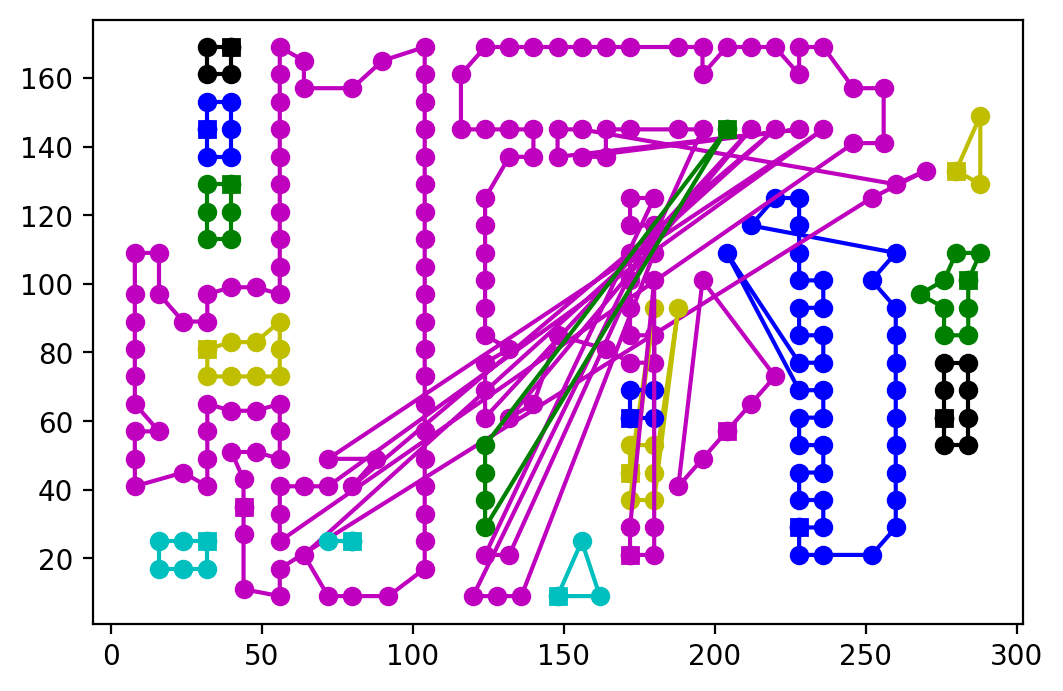

Adding cut for subtour: {'220', '208', '251', '257', '218', '263', '219', '211', '230', '249', '214', '250', '260', '252', '221', '215', '225', '254', '207', '228', '216', '212', '262', '253', '210', '224', '259', '229', '248', '213', '223', '226', '255', '217', '261', '222', '258', '227', '209', '256'}
Adding cut for subtour: {'044', '057', '045', '056', '058', '059'}
Adding cut for subtour: {'093', '095', '096', '097', '098', '094'}
Adding cut for subtour: {'273', '091', '106', '078', '122', '109', '129', '159', '187', '102', '163', '148', '067', '140', '153', '073', '101', '141', '014', '133', '128', '099', '190', '033', '061', '126', '188', '088', '279', '169', '022', '074', '138', '127', '060', '180', '120', '105', '003', '081', '026', '104', '123', '092', '041', '131', '008', '125', '030', '103', '034', '066', '268', '164', '162', '076', '151', '124', '270', '018', '121', '063', '072', '111', '031', '135', '165', '132', '077', '168', '043', '158', '189', '160', '005', '130', '009

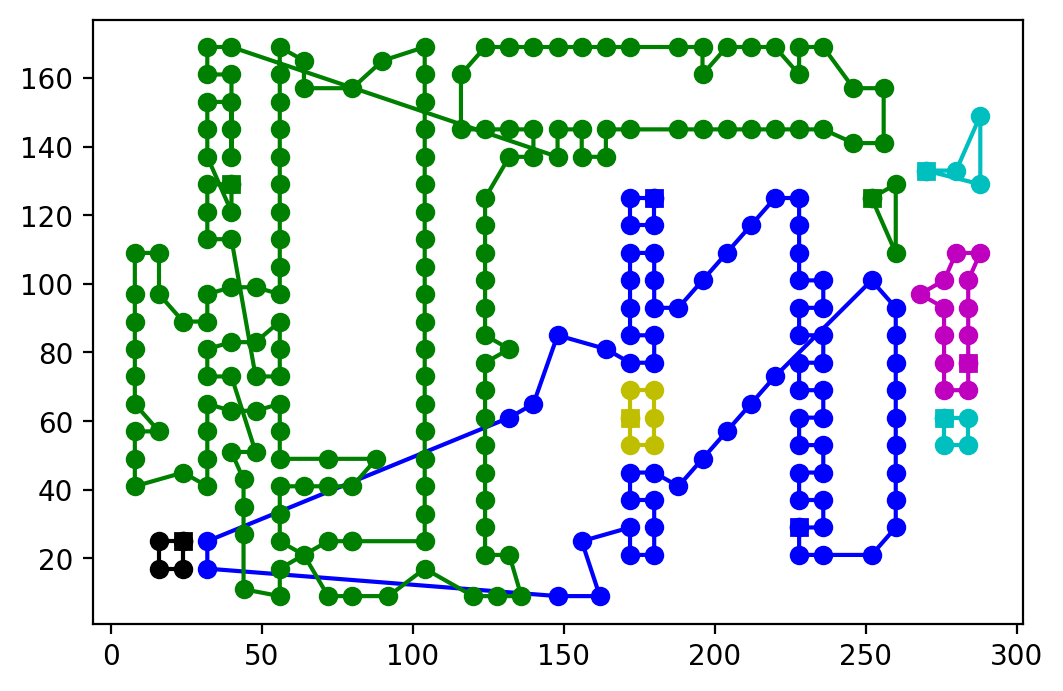

Adding cut for subtour: {'220', '208', '251', '192', '201', '093', '138', '191', '257', '180', '218', '196', '263', '219', '203', '193', '211', '265', '230', '249', '202', '194', '179', '149', '214', '250', '260', '252', '221', '148', '215', '150', '137', '225', '254', '207', '228', '140', '264', '216', '267', '212', '262', '253', '200', '268', '136', '141', '139', '210', '205', '224', '259', '098', '229', '256', '266', '213', '223', '226', '204', '198', '255', '261', '217', '195', '222', '197', '258', '227', '206', '209', '199'}
Adding cut for subtour: {'273', '045', '091', '106', '078', '122', '085', '109', '129', '159', '187', '049', '102', '163', '067', '184', '117', '153', '073', '101', '054', '114', '272', '014', '133', '128', '171', '099', '190', '061', '033', '126', '188', '088', '169', '022', '074', '127', '084', '060', '050', '120', '086', '105', '081', '057', '172', '026', '104', '123', '092', '041', '131', '048', '008', '030', '103', '125', '044', '170', '034', '066', '164'

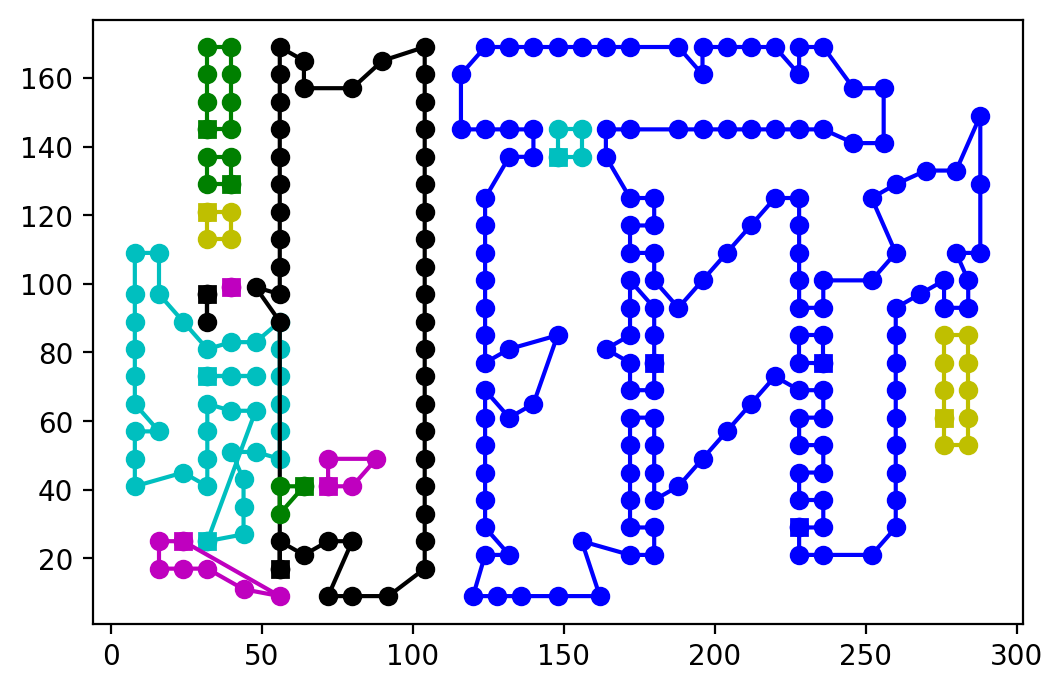

Adding cut for subtour: {'220', '273', '196', '219', '211', '129', '187', '144', '184', '215', '153', '272', '014', '133', '128', '190', '204', '222', '126', '258', '227', '188', '256', '199', '279', '022', '201', '127', '180', '146', '241', '003', '265', '230', '249', '026', '008', '207', '268', '200', '151', '270', '224', '259', '280', '018', '145', '255', '217', '135', '197', '210', '189', '001', '191', '218', '005', '263', '203', '130', '009', '194', '202', '178', '276', '029', '260', '221', '011', '002', '150', '154', '177', '228', '027', '176', '185', '155', '156', '242', '205', '229', '247', '143', '017', '277', '240', '223', '182', '213', '198', '261', '195', '251', '010', '192', '275', '257', '183', '269', '278', '007', '028', '193', '004', '179', '134', '021', '214', '250', '013', '016', '225', '254', '023', '271', '264', '216', '181', '267', '212', '262', '012', '243', '136', '025', '248', '274', '006', '015', '226', '024', '186', '245', '152', '244', '206'}
Adding cut for s

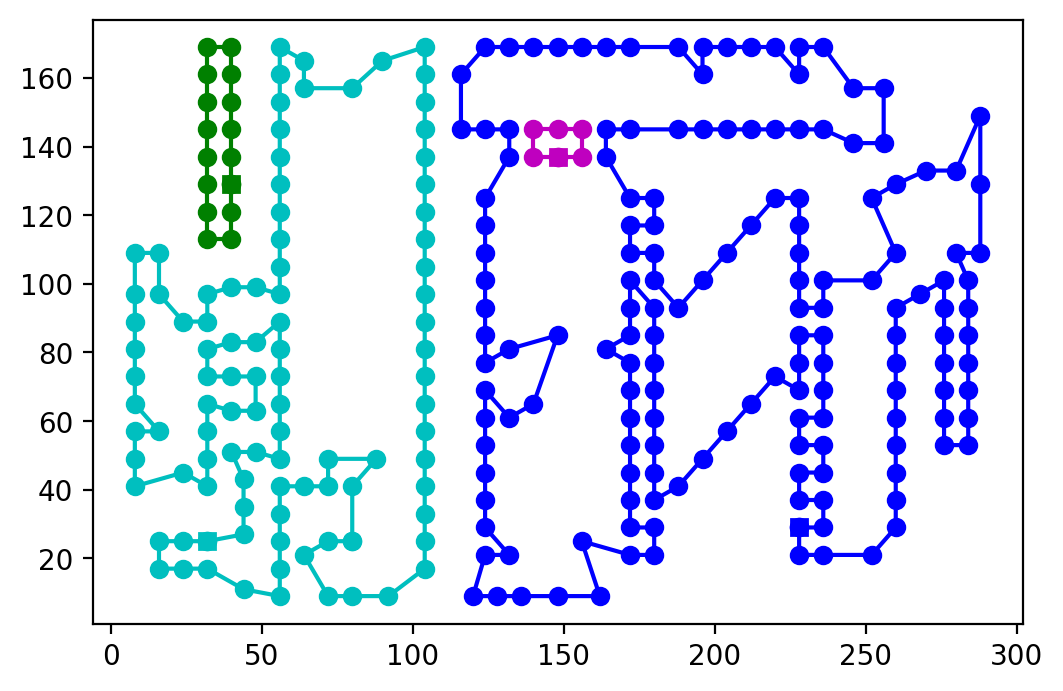

Adding cut for subtour: {'220', '273', '196', '219', '233', '211', '129', '234', '187', '252', '148', '144', '184', '215', '140', '153', '142', '141', '272', '014', '238', '133', '128', '190', '204', '222', '126', '258', '227', '188', '256', '199', '208', '279', '022', '201', '127', '138', '180', '146', '241', '003', '265', '230', '249', '026', '008', '207', '147', '253', '268', '200', '151', '270', '224', '259', '280', '018', '145', '255', '217', '135', '197', '210', '189', '001', '191', '218', '005', '263', '203', '009', '194', '202', '178', '149', '276', '029', '260', '221', '011', '002', '150', '154', '137', '177', '228', '027', '176', '185', '155', '156', '232', '242', '139', '205', '229', '247', '143', '017', '237', '235', '240', '223', '277', '182', '198', '213', '261', '195', '231', '209', '251', '010', '192', '275', '257', '183', '269', '278', '007', '028', '193', '004', '179', '134', '214', '250', '013', '016', '225', '254', '023', '271', '264', '216', '181', '267', '212', '2

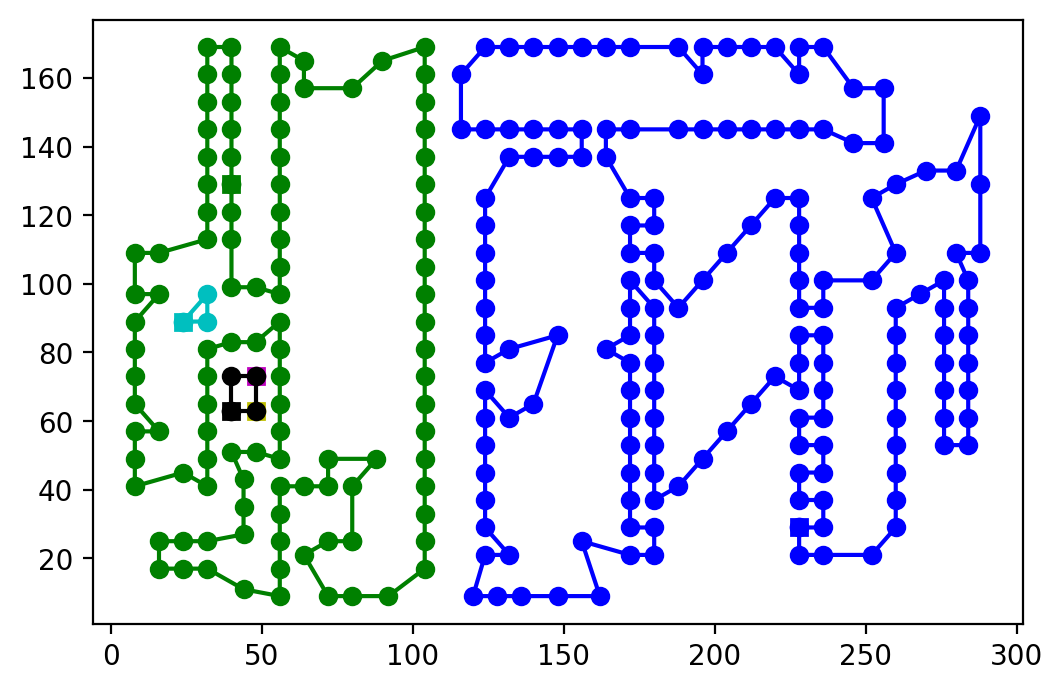

Adding cut for subtour: {'220', '273', '196', '219', '233', '211', '129', '234', '187', '252', '148', '144', '184', '215', '140', '153', '142', '141', '272', '014', '238', '133', '128', '190', '204', '222', '126', '258', '227', '188', '256', '199', '208', '279', '022', '201', '127', '138', '180', '146', '241', '003', '265', '230', '249', '026', '008', '131', '207', '147', '253', '268', '200', '151', '270', '224', '259', '280', '018', '145', '255', '217', '135', '197', '132', '210', '189', '001', '191', '218', '005', '263', '203', '130', '009', '194', '202', '178', '149', '276', '029', '260', '221', '011', '002', '150', '154', '137', '177', '228', '027', '176', '185', '155', '156', '232', '242', '139', '205', '229', '247', '143', '017', '237', '235', '240', '223', '277', '182', '198', '213', '261', '195', '231', '209', '019', '251', '010', '192', '275', '257', '183', '269', '278', '007', '028', '193', '004', '179', '134', '021', '214', '250', '013', '020', '016', '225', '254', '023', '2

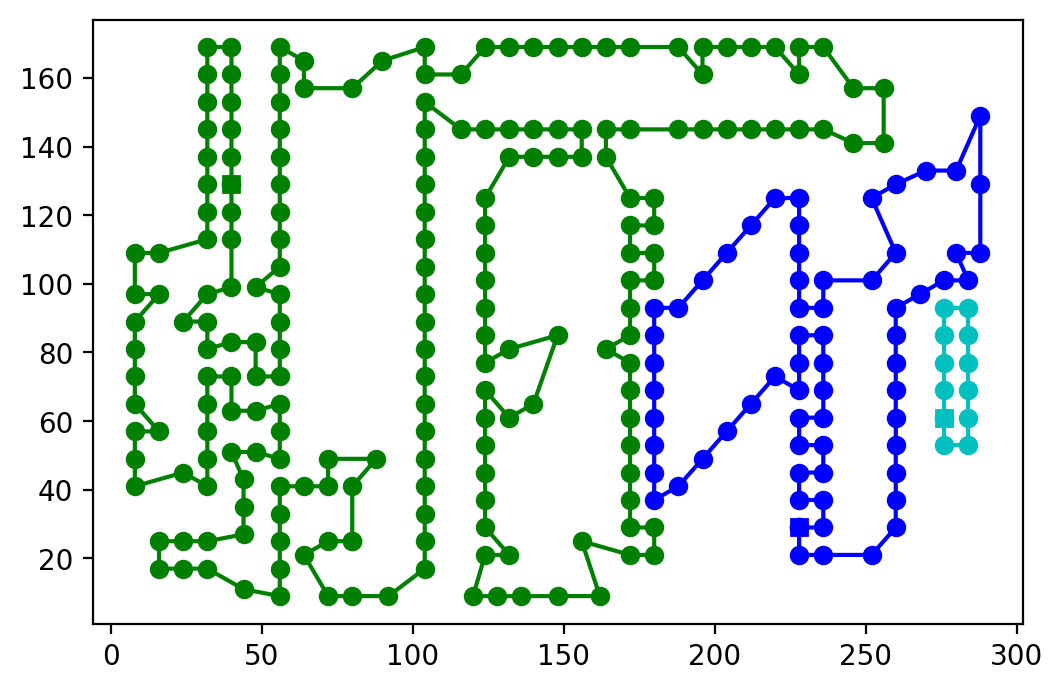

Adding cut for subtour: {'220', '208', '279', '251', '001', '201', '257', '218', '278', '263', '203', '219', '211', '241', '003', '265', '230', '249', '202', '214', '250', '260', '252', '221', '002', '144', '215', '225', '254', '207', '228', '264', '140', '216', '212', '262', '253', '200', '243', '242', '142', '141', '210', '205', '224', '259', '229', '247', '248', '280', '143', '266', '213', '223', '226', '255', '204', '217', '261', '222', '244', '258', '227', '206', '209', '256'}
Adding cut for subtour: {'273', '045', '093', '091', '106', '196', '122', '085', '078', '109', '129', '159', '187', '049', '102', '163', '148', '067', '184', '117', '153', '073', '101', '095', '054', '114', '272', '014', '133', '128', '171', '099', '190', '061', '033', '097', '126', '188', '088', '199', '169', '022', '084', '138', '127', '074', '060', '180', '096', '120', '086', '105', '050', '146', '094', '081', '057', '172', '026', '104', '123', '092', '041', '008', '131', '125', '030', '103', '048', '044'

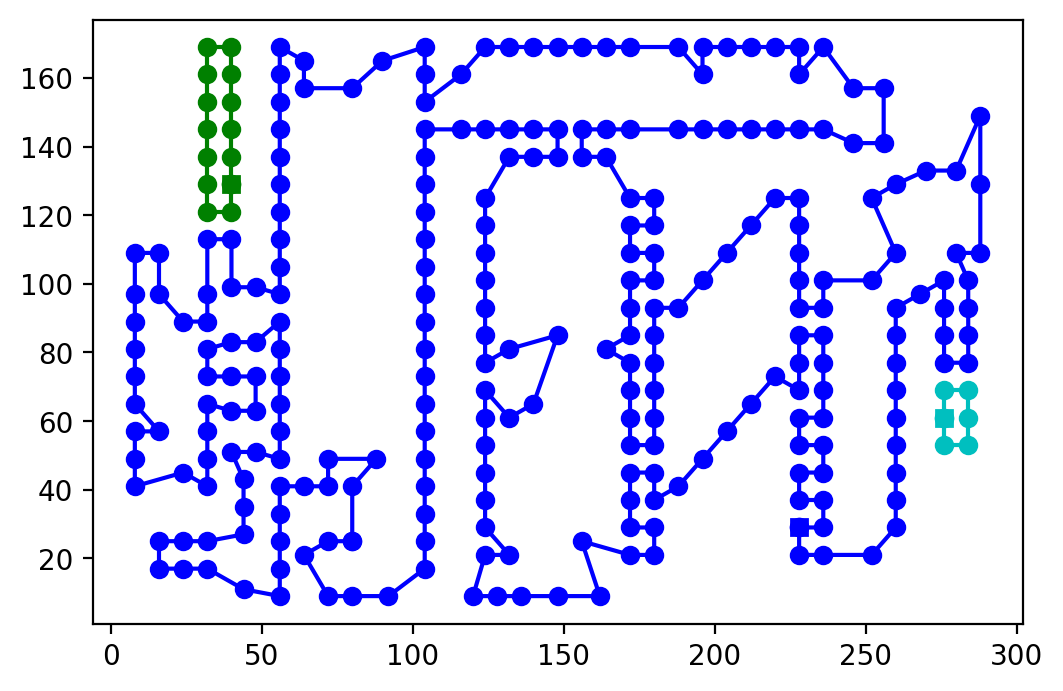

Adding cut for subtour: {'220', '273', '093', '091', '106', '078', '122', '085', '196', '219', '211', '109', '129', '159', '187', '102', '163', '252', '148', '067', '144', '184', '215', '117', '140', '153', '073', '101', '142', '095', '141', '114', '272', '014', '238', '133', '128', '171', '099', '190', '033', '061', '204', '097', '222', '126', '258', '227', '088', '188', '256', '199', '208', '279', '169', '022', '201', '074', '138', '084', '127', '060', '180', '096', '120', '086', '105', '146', '241', '003', '094', '265', '230', '249', '081', '172', '026', '104', '123', '092', '041', '008', '131', '125', '030', '103', '207', '147', '170', '034', '253', '066', '268', '164', '162', '200', '076', '151', '124', '270', '087', '224', '259', '059', '280', '145', '018', '063', '072', '111', '255', '121', '217', '031', '135', '165', '197', '132', '077', '210', '168', '043', '158', '189', '001', '160', '191', '218', '005', '263', '203', '113', '130', '009', '075', '173', '194', '039', '079', '0

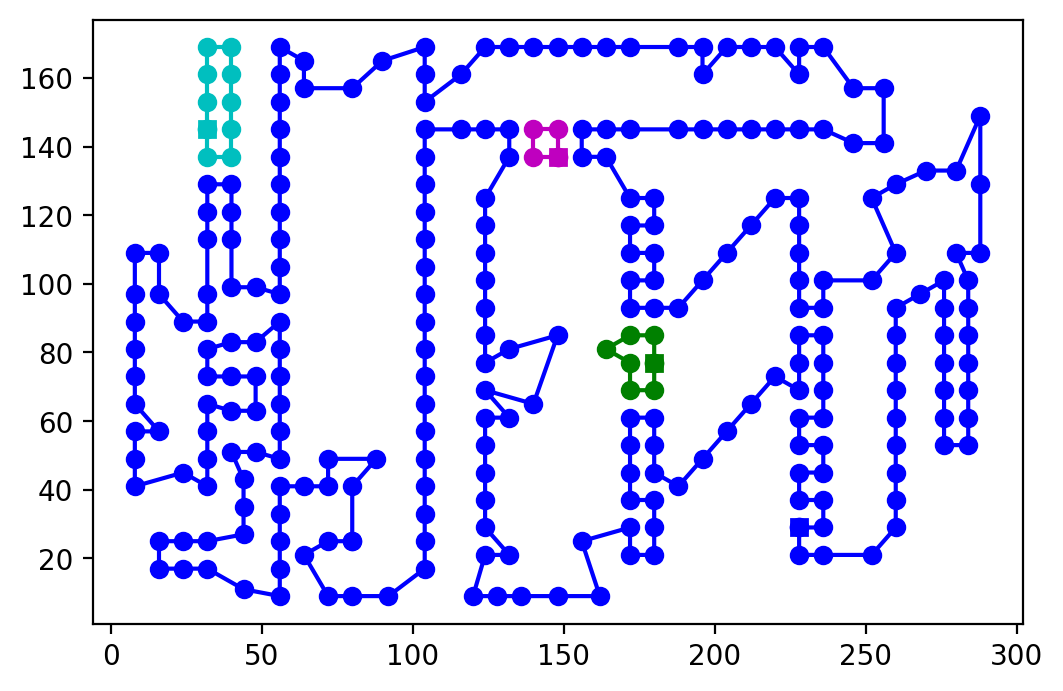

Adding cut for subtour: {'220', '273', '045', '093', '091', '106', '078', '122', '085', '196', '219', '070', '233', '211', '109', '129', '234', '159', '187', '102', '163', '252', '067', '144', '184', '215', '117', '153', '073', '101', '095', '114', '272', '014', '238', '133', '128', '171', '099', '190', '033', '061', '204', '097', '222', '126', '258', '227', '088', '188', '256', '199', '208', '279', '169', '022', '201', '074', '138', '084', '127', '060', '180', '096', '120', '086', '105', '146', '241', '003', '094', '265', '230', '249', '081', '057', '172', '026', '104', '123', '092', '041', '008', '207', '125', '030', '103', '044', '170', '034', '253', '066', '268', '164', '162', '200', '076', '151', '124', '270', '087', '224', '259', '059', '280', '018', '121', '063', '072', '111', '255', '145', '217', '031', '135', '165', '197', '132', '077', '210', '168', '043', '158', '189', '001', '160', '191', '218', '005', '263', '203', '113', '009', '075', '173', '194', '039', '079', '042', '1

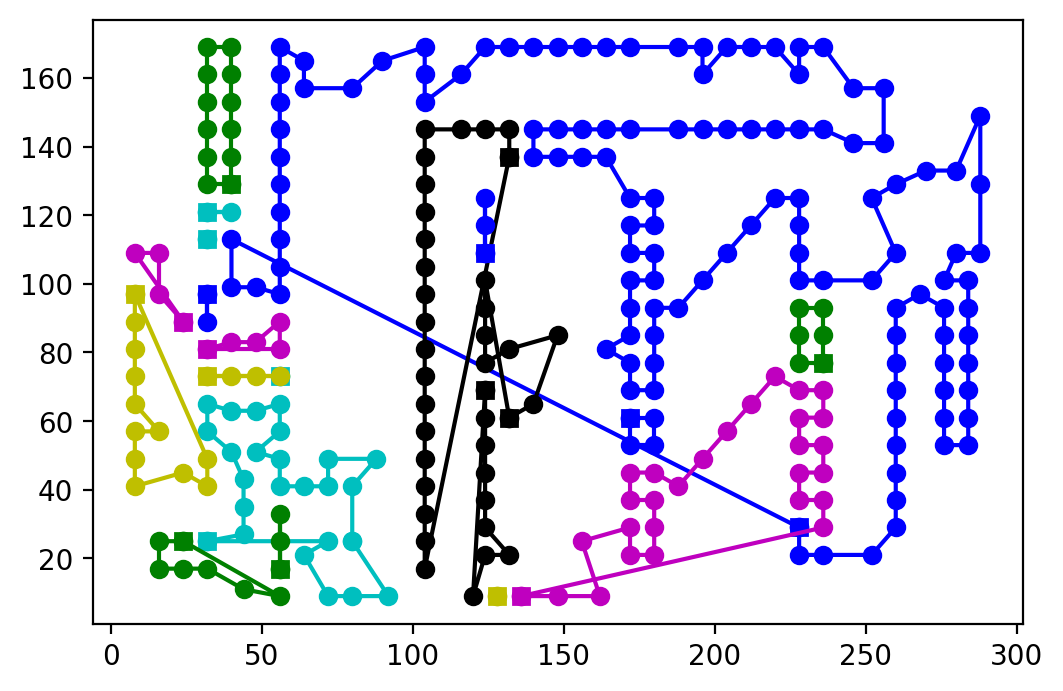

Adding cut for subtour: {'220', '273', '233', '234', '148', '140', '142', '141', '272', '014', '238', '133', '033', '061', '222', '258', '227', '256', '279', '022', '138', '060', '241', '003', '265', '230', '249', '026', '041', '131', '008', '030', '147', '034', '268', '270', '224', '259', '059', '280', '018', '063', '031', '135', '132', '043', '001', '005', '263', '130', '009', '039', '042', '149', '276', '029', '260', '221', '011', '002', '037', '137', '228', '027', '232', '242', '139', '032', '062', '229', '035', '247', '017', '237', '235', '240', '223', '277', '261', '231', '038', '019', '251', '010', '275', '257', '269', '278', '007', '118', '028', '004', '134', '021', '250', '013', '020', '016', '036', '225', '023', '040', '271', '264', '267', '262', '012', '243', '136', '025', '248', '274', '266', '006', '015', '226', '024', '246', '245', '244', '239', '236'}
Adding cut for subtour: {'047', '049', '046', '045', '056', '051', '052', '053', '050', '054', '055', '048'}
Adding cut f

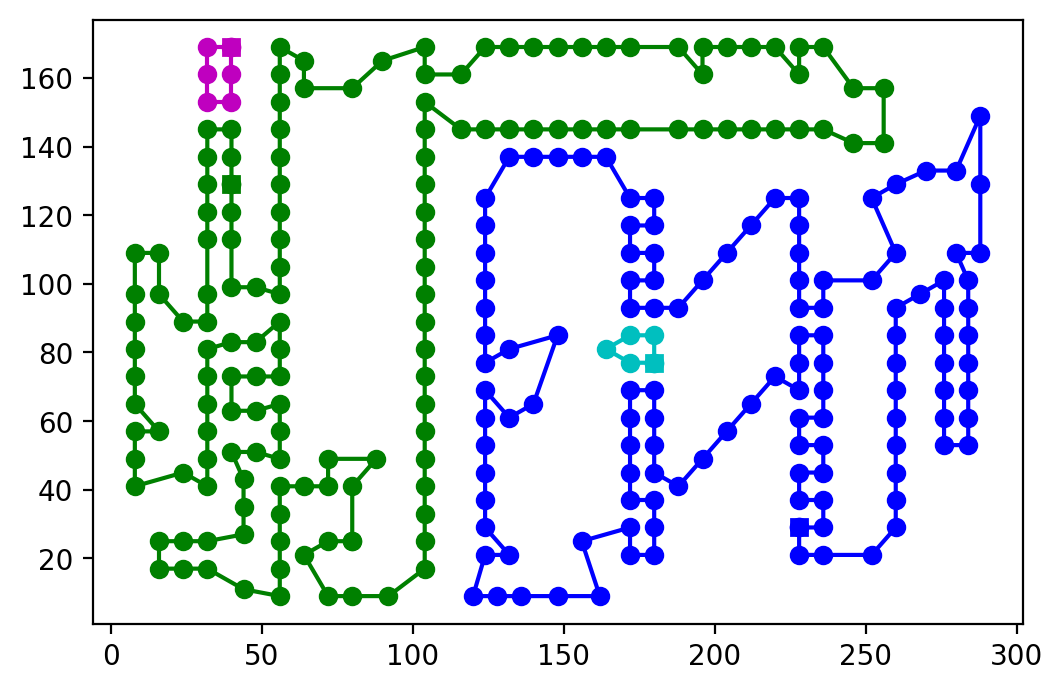

Adding cut for subtour: {'220', '196', '219', '233', '211', '129', '234', '187', '252', '144', '184', '215', '153', '142', '238', '133', '190', '204', '222', '258', '227', '188', '256', '199', '208', '279', '201', '138', '180', '146', '241', '003', '265', '230', '249', '131', '207', '147', '253', '268', '200', '151', '270', '224', '259', '280', '145', '255', '217', '135', '197', '132', '210', '189', '001', '191', '218', '263', '203', '130', '194', '202', '178', '260', '221', '002', '150', '154', '137', '177', '228', '176', '185', '155', '156', '232', '242', '205', '229', '247', '143', '237', '235', '240', '223', '182', '213', '198', '261', '195', '231', '209', '251', '192', '257', '183', '269', '278', '193', '179', '134', '214', '250', '225', '254', '216', '264', '181', '267', '212', '262', '243', '136', '248', '266', '226', '246', '245', '152', '186', '244', '206', '239', '236'}
Adding cut for subtour: {'273', '045', '093', '091', '106', '078', '122', '085', '109', '159', '102', '163'

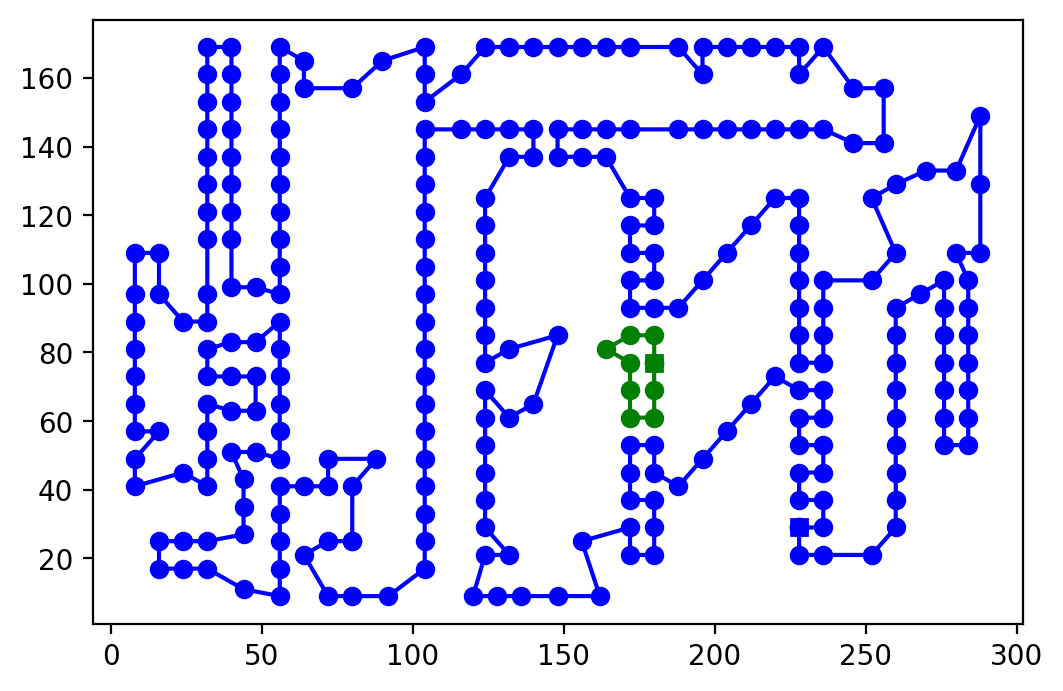

Adding cut for subtour: {'220', '273', '045', '093', '091', '106', '078', '122', '085', '196', '219', '070', '233', '211', '109', '129', '234', '159', '187', '049', '102', '252', '163', '067', '144', '184', '215', '117', '153', '073', '101', '095', '054', '114', '272', '014', '238', '133', '128', '171', '099', '190', '033', '061', '204', '097', '222', '126', '258', '227', '088', '188', '256', '208', '199', '279', '169', '022', '201', '074', '138', '084', '127', '060', '180', '050', '096', '086', '105', '120', '241', '003', '094', '265', '230', '249', '081', '057', '172', '026', '104', '123', '092', '041', '131', '008', '048', '030', '103', '125', '044', '207', '170', '034', '253', '066', '268', '164', '162', '200', '076', '151', '124', '270', '087', '224', '259', '059', '280', '018', '121', '063', '072', '111', '255', '145', '217', '031', '135', '165', '197', '132', '077', '210', '168', '043', '158', '189', '001', '160', '191', '218', '005', '263', '203', '113', '130', '009', '075', '1

In [16]:
t0 = time()
if not USE_CALLBAKCS:
    amplSubTourElimination(ampl)
else:
    solverSubTourElimination(ampl, SOLVER, SOLVER_OPTIONS)

Get the solution, print it and display it

['220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '251', '250', '247', '244', '245', '246', '231', '232', '233', '234', '235', '236', '237', '238', '239', '240', '241', '243', '242', '002', '001', '280', '003', '279', '278', '248', '249', '256', '255', '252', '209', '208', '253', '254', '257', '258', '259', '260', '261', '262', '263', '264', '265', '266', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '139', '138', '137', '267', '268', '136', '135', '269', '270', '134', '133', '132', '131', '130', '021', '020', '019', '018', '017', '016', '271', '272', '273', '274', '275', '276', '277', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '015', '014', '024', '023', '025', '022', '026', '027', '028', '029', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '060', '061', '118', '062', '063', '059', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055'

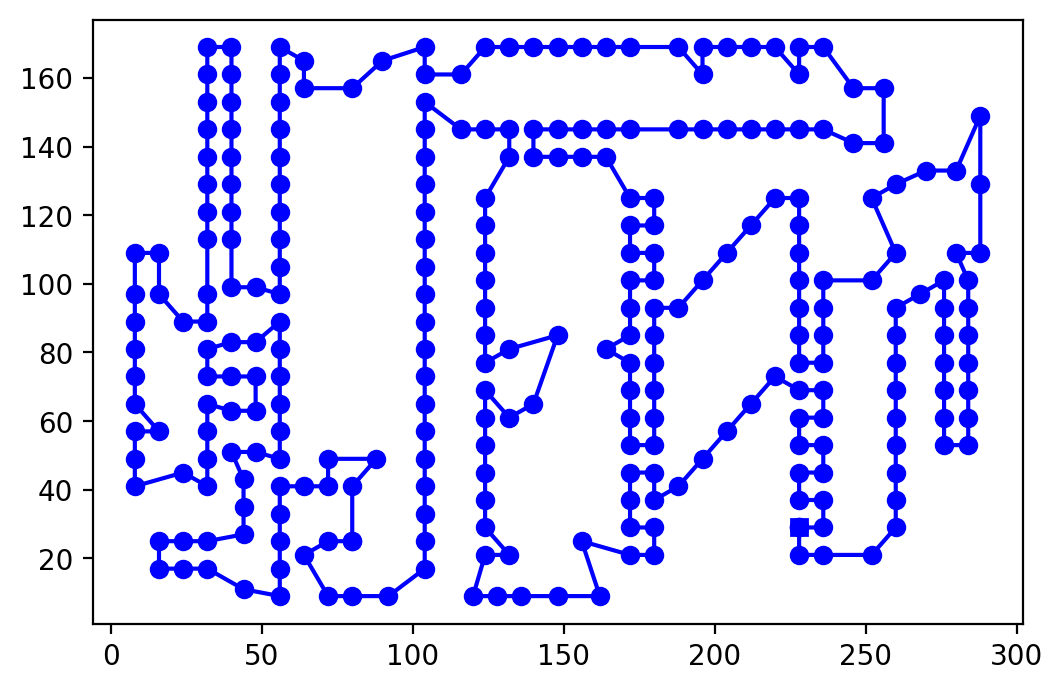

In [17]:
# Get the solution into ARCS
ARCS = ampl.getData("{(i,j) in PAIRS : X[i,j] > 0} X[i,j];")
ARCS = set([(i,j) for (i,j,k) in ARCS.toList()])

# Display it
tours = findSubTours(ARCS, NODES)
for st in tours:
    print(st)
plotTours(tours, CPOINTS)

In [18]:
ampl.getValue('Tour_Length')

2586.7696475631615

In [19]:
time()-t0

25.829950094223022